# Plot German RLM or SLP Demand against TTF Close price 


Below is an example of how to connect to Eikon Data API and RDMS API to plot curve and RICS data together. This will enable the observation of any correlation between price and fundamental price driver.

- We access the TTF Daily close price from the Eikon Data API.

- We access EU Gas Actuals and Forecast data from RDMS.

At the end of this notebook we will plot:

1. Actual consumption
2. The latest EC15 and EC46 forecasts
3. A range of EC15 forecasts from the past year 
4. We will use the Meta data from RDMS to populate the graph automatically
5. Plot DA close price to observe correlations.


> **Author: EU Gas Research Team**   
**Created: September 2023**

> <span style='background :lightblue' > **You need a RDMS and Eikon Data API keys saved under C:/python/api_key.txt to use this script** </span>  
(or you can change the path in the code to be the location of api_key.txt file)
An api_key.txt file format is
>> ,value  
eikon_api_key,YOUR_EIKON_DATA_API_KEY  
RDMS_api_key,YOUR_RDMS_API_KEY  


# Step 1) Preamble

## Package import

In [1]:
# Standard python packages
import requests,json, io,warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Eikon LSEG Eikon package
import eikon as ek # Eikon data pipeline

In [2]:
# Load API keys from the text file
keys = pd.read_csv("api_key.txt", index_col = 0) # Get keys
# print(keys.loc['eikon_api_key', 'value'])
# print(keys.loc["RDMS_api_key"].value)
print('The API keys are loaded into the Notebook')

The API keys are loaded into the Notebook


## API KEYS
We set up connections for RDMS and Eikon Data API

In [3]:
keys = pd.read_csv("api_key.txt", index_col = 0) # Get keys

ek.set_app_key(keys.loc['eikon_api_key', 'value'])  # Set access key for Eikon
headers = {# Headers for autherisation for RMDS
           "Accept": "text/csv",
           "Authorization": keys.loc["RDMS_api_key"].value
          }
del keys

# Base urls for RDMS REST API Access
url ='https://analyst.rdms.refinitiv.com/api/v1/CurveValues/'
url_meta='https://analyst.rdms.refinitiv.com/api/v1/Metadata/'

## Curve ID's  and RICS wanted

In [4]:
"""
# DE RLM
DE_actuals=142173968
DE_Forecast_EC15=117622266 # EC15, freq = hours
DE_Forecast_EC46=117622613 # EC46, freq = twice a week
"""

# DE SLP
DE_actuals=142173967
DE_Forecast_EC15=117622222 # EC15, freq = hours
DE_Forecast_EC46=117622569 # EC46, freq = twice a week

# Pricing RIC
rics=['TRNLTTFD1'] # TTF Gas price daily close price 

(Optional) This cell is just to print out the metadata of each Curve ID used for more information

In [5]:
curve_ids = ['142173968','117622266','117622613','142173967','117622222','117622569']

df_metadata = None

for curve_id in curve_ids:
    url_metadata = url_meta + curve_id
    response = requests.request("GET", url_metadata, headers=headers)
    string_data = response.content.decode('utf-8')
    df_temp = pd.read_csv(io.StringIO(string_data))
    if(df_metadata is None):
        df_metadata = df_temp
    else:
        df_metadata = df_metadata.append(df_temp)
display(df_metadata)

,CurveID,Curve Name,Commodity,Provider.is,Variable.is,Geography.is,Value.Frequency.is,Status.is,Unit.is,Timezone.is,...,Source,Commodity.is,Provider,Unit,Issue.Frequency.is,Market.is,Sector.is,Regime.is,Dataset.In.is,Dataset.Calculation.is
0,142173968,EUContGas_Balance.;ch4;con;DEU;daily;THE;NONLD...,Gas,Point Carbon,Consumption,Germany,Days (1),Actual,gigawatt hour per day,CET,...,PointConnect,Methane,Point Carbon,GWh/day,Days (1),Trading Hub Europe,"Power, Industrial",NaN,NaN,NaN
0,117622266,EUGasCons2010.EC.Ens;;DE;RLM;;AVG;CON;CH4;GWh/...,Gas,Point Carbon,Consumption,Germany,Days (1),Forecast,gigawatt hour per day,CET,...,PointConnect,Methane,NaN,NaN,Hours (12),NaN,NaN,Metered Consumption (RLM),ECMWF.Ensemble,Average across series
0,117622613,EUGasCons2010.EC.Wkly;;DE;RLM;;AVG;CON;CH4;GWh...,Gas,Point Carbon,Consumption,Germany,Days (1),Forecast,gigawatt hour per day,CET,...,PointConnect,Methane,NaN,NaN,Twice a week,NaN,Total All Sectors,Metered Consumption (RLM),ECMWF.Ens Weekly Long Term,Average across series
0,142173967,EUContGas_Balance.;ch4;con;DEU;daily;THE;LDZ;P...,Gas,Point Carbon,Consumption,Germany,Days (1),Actual,gigawatt hour per day,CET,...,PointConnect,Methane,Point Carbon,GWh/day,Days (1),Trading Hub Europe,Residential,NaN,NaN,NaN
0,117622222,EUGasCons2010.EC.Ens;;DE;SLP;;AVG;CON;CH4;GWh/...,Gas,Point Carbon,Consumption,Germany,Days (1),Forecast,gigawatt hour per day,CET,...,PointConnect,Methane,NaN,NaN,Hours (12),NaN,Residential,Standard Load Profile (Synthetic),ECMWF.Ensemble,Average across series
0,117622569,EUGasCons2010.EC.Wkly;;DE;SLP;;AVG;CON;CH4;GWh...,Gas,Point Carbon,Consumption,Germany,Days (1),Forecast,gigawatt hour per day,CET,...,PointConnect,Methane,NaN,NaN,Twice a week,NaN,Residential,Standard Load Profile (Synthetic),ECMWF.Ens Weekly Long Term,Average across series


# Step 2) Useful times and dates

In [6]:
Today= datetime.today()                                                

# Dates to pull data between
# To cover all the data needed we go back 6 years and forwards to end of next calander year.
Forecast_start = datetime(year=Today.year-6, month = 1, day = 1) 
Forecast_end   = datetime(year=Today.year+1, month = 12, day = 1) 

# Value date range
Value_start = Forecast_start
Value_end   =   Forecast_end

print('Date range: from {} \n            to   {}'.format(Forecast_start, Forecast_end));

Date range: from 2017-01-01 00:00:00 
            to   2024-12-01 00:00:00


# Step 3) My Functions

In [7]:
def get_RDMS_meta(url,CurveID):
    '''
    This function retrives curve meta from RDMS
    '''    
        
    CURVE=url+str(CurveID)
    response = requests.request("GET",CURVE , headers=headers).content
    rawData = pd.read_csv(io.StringIO(response.decode('utf-8')))
    return rawData

def get_RDMS_data(url,CurveID,Value_start,Forecast_start=None):
    '''
    This function retrives data from RDMS
    '''    
    
    if Forecast_start == None:
        CURVE=url+str(CurveID)
        MinValueDate=str(Value_start).replace(" ","T")
        CURVE=CURVE+"?MinValueDate="+MinValueDate
    else:
        CURVE=url+str(CurveID)
        MinValueDate=str(Value_start).replace(" ","T")
        MinForecastDate=str(Forecast_start).replace(" ","T")        
        CURVE=CURVE+"?MinForecastDate="+MinForecastDate+"&MinValueDate="+MinValueDate
    print (CurveID,"->", CURVE)   
    
    response = requests.request("GET",CURVE , headers=headers).content
    rawData = pd.read_csv(io.StringIO(response.decode('utf-8'))) 
    
    return rawData


def sort_forecast(dataF):
    '''
    This produces dictonary of forecast data using the datetime stamp as KEY.
    Allows for easy plotting of various forecasts
    '''        
    Forecasts={}
    Forecast_FD=dataF.groupby("ForecastDate")

    for G in Forecast_FD:
        # clean up key for nice visual
        KEY=str(G[0]).replace("Timestamp","").replace("'","")
        Forecasts[KEY]=G[1].drop(columns=["ForecastDate"]).set_index("ValueDate").rename({"Value":KEY},axis=1)
        
    # Clean up naming from UTC  back to CET
    for K in list(Forecasts.keys()):
        new_key=K.replace('01:00:00','00:00:00').replace('02:00:00','00:00:00').replace('13:00:00','12:00:00').replace('14:00:00','12:00:00')
        Forecasts[new_key] = Forecasts.pop(K)
        Forecasts[new_key].rename({K:new_key},axis=1,inplace=True)   
        
    return Forecasts

def create_daily_forecast(EC,Which_forecast_day,Forecasts):
    '''
    This creates a daily forecast from either EC15 or EC46 data.
    ie Day ahead forecast is day Which_forecast_day= 1  
    '''
    daily_forecast=pd.DataFrame(columns=["DA-"+str(Which_forecast_day)+" Forecast","ForecastDate"])

    for i, fil in enumerate(list(Forecasts.keys())):
        if EC+":" in fil:
            DAV=Forecasts[fil].iloc[Which_forecast_day].values[0]
            daily_forecast.loc[i,"DA-"+str(Which_forecast_day)+" Forecast"]=DAV
            daily_forecast.loc[i,"ForecastDate"]=fil.split(" ")[0]
            
    daily_forecast=daily_forecast.set_index("ForecastDate")
    daily_forecast.index=daily_forecast.index.astype('datetime64[ns]')
  
    return daily_forecast

# Step 4) Curves and metadata

In [8]:
Meta_actuals=get_RDMS_meta(url_meta,DE_actuals).T.rename({0:"meta"},axis=1).rename({"":"Meta"},axis=1)

# For use in the graph decoration
Sector  = Meta_actuals.loc["Sector.is"][0]
Country = Meta_actuals.loc["Geography.is"][0]
Unit    = Meta_actuals.loc["Unit"][0]
Variable = Meta_actuals.loc["Variable.is"][0]

print(Meta_actuals.index)

Index(['CurveID', 'Curve Name', 'Commodity', 'Provider.is', 'Variable.is',
       'Geography.is', 'Value.Frequency.is', 'Status.is', 'Unit.is',
       'Timezone.is', 'FileFolder', 'FileStub', 'FileID', 'Source',
       'Commodity.is', 'Provider', 'Unit', 'Issue.Frequency.is', 'Market.is',
       'Sector.is'],
      dtype='object')


# Step 5) Get RDMS data and format them

In [9]:
# Get actuals data
dataA=get_RDMS_data(url,DE_actuals,Value_start,None)
dataA=dataA.drop(columns=["ForecastDate","ScenarioID"])                # Drop forecast date as this is a time series curve
dataA["ValueDate"]= pd.to_datetime(dataA["ValueDate"])
dataA=dataA.rename({"Value":"Actuals"},axis=1).set_index("ValueDate")  # Rename and set index

# Forecast data for EC15. 
dataF_EC15=get_RDMS_data(url,DE_Forecast_EC15,Value_start,Forecast_start)
dataF_EC15=dataF_EC15.drop(columns=["ScenarioID"]) 
dataF_EC15["ValueDate"]= pd.to_datetime(dataF_EC15["ValueDate"])

# Forecast data for EC46.
dataF_EC46=get_RDMS_data(url,DE_Forecast_EC46,Value_start,Forecast_start)
dataF_EC46=dataF_EC46.drop(columns=["ScenarioID"]) 
dataF_EC46["ValueDate"]= pd.to_datetime(dataF_EC46["ValueDate"])

142173967 -> https://analyst.rdms.refinitiv.com/api/v1/CurveValues/142173967?MinValueDate=2017-01-01T00:00:00
117622222 -> https://analyst.rdms.refinitiv.com/api/v1/CurveValues/117622222?MinForecastDate=2017-01-01T00:00:00&MinValueDate=2017-01-01T00:00:00
117622569 -> https://analyst.rdms.refinitiv.com/api/v1/CurveValues/117622569?MinForecastDate=2017-01-01T00:00:00&MinValueDate=2017-01-01T00:00:00


## Create a list of forecasts
Sort forcasts in dict and convert to UTC (replace string in key is a simple method)

In [10]:
Forecasts_EC15=sort_forecast(dataF_EC15)
Forecasts_EC46=sort_forecast(dataF_EC46)

## Create a Day Ahead forecast

If we take the first day of each forecast, this will be the Day Ahead forecast which will be the most predictive forecast in terms of weather forecast error impact predicability. We can do this for any of our forecasts (EC,GFS, ENS or Op). Below we will use our EC12 forcast which used for our morning comment.

In [11]:
EC="12" 
Which_forecast_day=1 # EC12 - 1 to 15 days out possible
Day_ahead=create_daily_forecast(EC,Which_forecast_day,Forecasts_EC15)
Day_ahead

,DA-1 Forecast
ForecastDate,
2020-01-20,2195.70732
2020-01-21,2257.060905
2020-01-22,2276.555696
2020-01-23,2326.816645
2020-01-24,2280.924652
...,...
2023-09-20,253.124066
2023-09-21,302.281864
2023-09-22,424.328188


# Step 6) Get prices

In [12]:
PRICES=ek.get_timeseries(rics,fields='CLOSE',start_date=Forecast_start.strftime('%Y-%m-%d'))
PRICES=PRICES.rename({PRICES.columns[0]:str(rics[0])+" "+PRICES.columns[0]},axis=1) #Rename to at price type into name
PRICES

TRNLTTFD1,TRNLTTFD1 CLOSE
Date,
2017-01-02,19.4
2017-01-03,18.5
2017-01-04,19.38
2017-01-05,18.77
2017-01-06,18.65
...,...
2023-09-19,37.55
2023-09-20,38.35
2023-09-21,39.57


# Step 7) Plot Actuals and forecast

(18993.0, 19661.0)

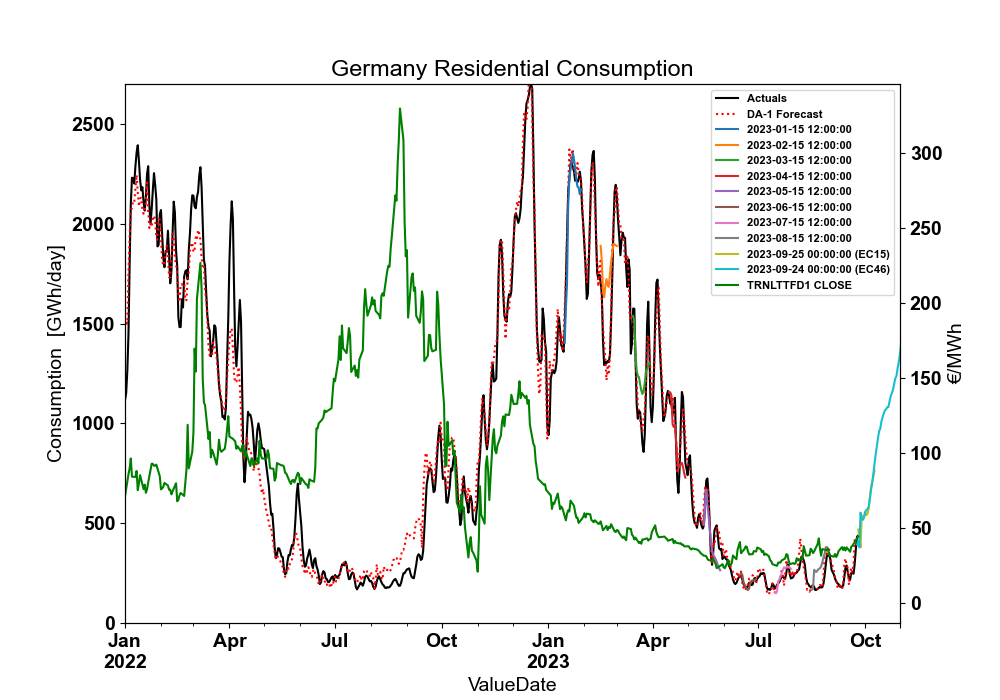

In [13]:
# Inteactive notebook plots
%matplotlib widget

# Set plot style
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# Iniciate plot
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()

# Turn on interactice plot toolbars
fig.canvas.toolbar_visible = True
fig.canvas.header_visible = True
fig.canvas.resizable = True


# Plot actuals
#------------
dataA.plot(ax=ax1,color="k")

# Plot DA forecast
#-----------------
Day_ahead.plot(ax=ax1,color="r",linestyle=":")

# Plot a seclection of forecasts
#-------------------------------
Forecasts_EC15['2023-01-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-02-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-03-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-04-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-05-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-06-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-07-15 '+str(EC)+':00:00'].plot(ax=ax1)
Forecasts_EC15['2023-08-15 '+str(EC)+':00:00'].plot(ax=ax1)

# Plot latest forecast
#---------------------
# EC15
Latest=dataF_EC15["ForecastDate"].tail(1).values[0].replace('01:00:00','00:00:00').replace('02:00:00','00:00:00').replace('13:00:00','12:00:00').replace('14:00:00','12:00:00')
Forecasts_EC15[Latest].add_suffix(' (EC15)').plot(ax=ax1)
# EC46
Latest=dataF_EC46["ForecastDate"].tail(1).values[0].replace('01:00:00','00:00:00').replace('02:00:00','00:00:00').replace('13:00:00','12:00:00').replace('14:00:00','12:00:00')
Forecasts_EC46[Latest].add_suffix(' (EC46)').plot(ax=ax1)

# Plot prices
#------------
PRICES.plot(ax=ax2,color="green")

# Finalise plot properties
#-------------------------
# Title
plt.title("{} {} {}".format(Country,Sector,Variable))

# Axis labels
plt.xlabel('{}'.format(dataA.index.name)) 
ax1.set_ylabel('{}  [{}]'.format(Variable,Unit))
ax2.set_ylabel('{}'.format("€/MWh"))

# Combine legend labels and keep together
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2,prop={'size': 8})
ax1.get_legend().remove()

# Set axis limits
ax1.set_ylim([0,dataA["Actuals"].max()])
ax1.set_xlim(["2022-01-01","2023-10-31"])

"""
# DE SLP
DE_actuals=142173967
DE_Forecast_EC15=117622222
DE_Forecast_EC46=117622569
"""

# Observations and Conclusions
Using the notebook, we were able to easily plot data using a matplotlib a chart to compare TTF price, actual consumption data and forecast consumption data. Two graphs can be seen in Figures 1 and 2 respectively. Firstly, SLP plotted against TTF and secondly RLM plotted against TTF.  
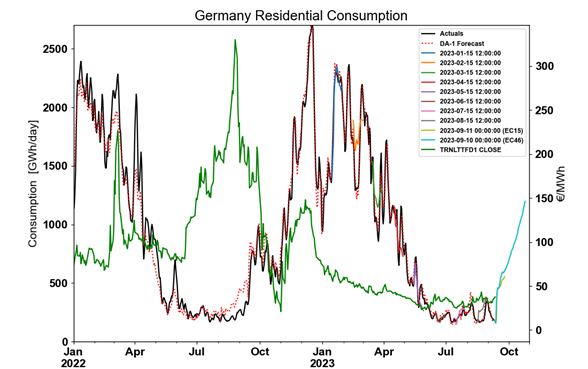
**Figure 1** – German SLP demand actuals benchmarked against weather based, EC15, EC46 and Day Ahead forecasts. TTF Daily Close price is also plotted on a second axis.  

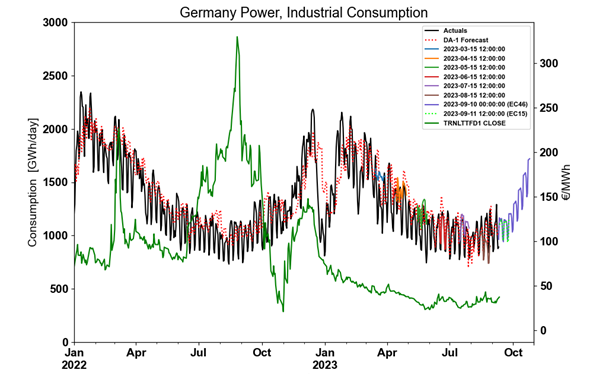
**Figure 2**– German RLM demand actuals benchmarked against weather-based forecasts and plotted with TTF Daily Close price.  

- Both the EC15 and EC46 forecasts correlate well with historical actuals consumption data.
- SLP and RLM have different consumption profiles.
   - SLP is seasonal, temperature driven and increases significantly in winter.
   - RLM demand has an added weekly periodicity to its profile due to demand being lower at weekends.
- There are clear times of the year such as at the start of the calendar year where the drop in consumption correlates to a general fall in TTF price for both SLP and RLM.
- TTF price in summer 2022 was primarily driven by supply-side concerns and influenced heavily by sentiment-based volatility. This meant prices decoupled from fundamental drivers and prices spiked. This is clear when comparing this to 2023 which saw a more “typical” price profile for TTF which is decreasing in summer as European Storages get filled.

# References
1. EU RESIDENTIAL & COMMERCIAL GAS CONSUMPTION MODEL Methodology paper on Workspace
2. Trading Hub Europe: https://www.tradinghub.eu/

For any questions related to the RDMS and Eikon Data API usage, feel free to visit or ask you question in the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/index.html).

### Thank you